#<b>Testing Different Data Augmentation Methods

In this notebook, we will train and test our best-performing CNN model using an image data generator. The model will be trained and tested seven times using a single image data generator technique.<br> 
To avoid overfitting, all models will use a callbacks function to stop fitting the model once it reaches the best validation loss, with a maximum of 20 epochs. Also, they will be trained using 32 batch size and 0.001 learning rate.

####<B>Mounting the Drive

In [ ]:
# Mounting the drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###<b>Loading libraries</b>

In [ ]:
# Importing libraries required to load the data
import zipfile

import os

from PIL import Image

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf

from keras.utils import to_categorical

from keras.layers import LeakyReLU

from tensorflow.keras import optimizers

from tensorflow.keras.layers import BatchNormalization

# To ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)

pd.set_option("display.max_rows", 200)

### <b>Load the data</b>

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall()

In [ ]:
# Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [ ]:
# Running the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
    
        try:
    
            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
                
                train_labels.append(1)
            
            else:
            
                train_labels.append(0)
        
        except Exception:
        
            pass       

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

In [ ]:
# Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [ ]:
# Running  the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
     
        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))
            
            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
                
                test_labels.append(1)
            
            else:
            
                test_labels.append(0)
        
        except Exception:
        
            pass       

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

###<b>Normalize the images

In [ ]:
# Normalizing the train and test images 
train_images = (train_images/255.0).astype('float32')

test_images = (test_images/255.5).astype('float32')

###<B>One Hot Encoding on the train and test labels

In [ ]:
# Encoding Train Labels
train_labels = to_categorical(train_labels, 2)

# Encoding test labels
test_labels = to_categorical(test_labels, 2)

###<B>Creating functions for plotting

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

In [ ]:
# Function to plot train and validation loss
def plot_loss(history):

    N = len(history.history["loss"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["loss"], label = "train_loss", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_loss"], label = "val_loss", ls = '--')

    plt.title("Loss vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Loss")
    
    plt.legend(loc="upper left")

In [ ]:
# Clearing backend
from tensorflow.keras import backend

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from random import shuffle

backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

###<b> First Model Using Zoom

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(#horizontal_flip = True, 
                                  #vertical_flip = False, 
                                  #height_shift_range= 0.1, 
                                  #width_shift_range=0.1, 
                                  #rotation_range=20, 
                                  #shear_range = 0.1,
                                  zoom_range=0.1)

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

####<B>Visualizing Augmented images

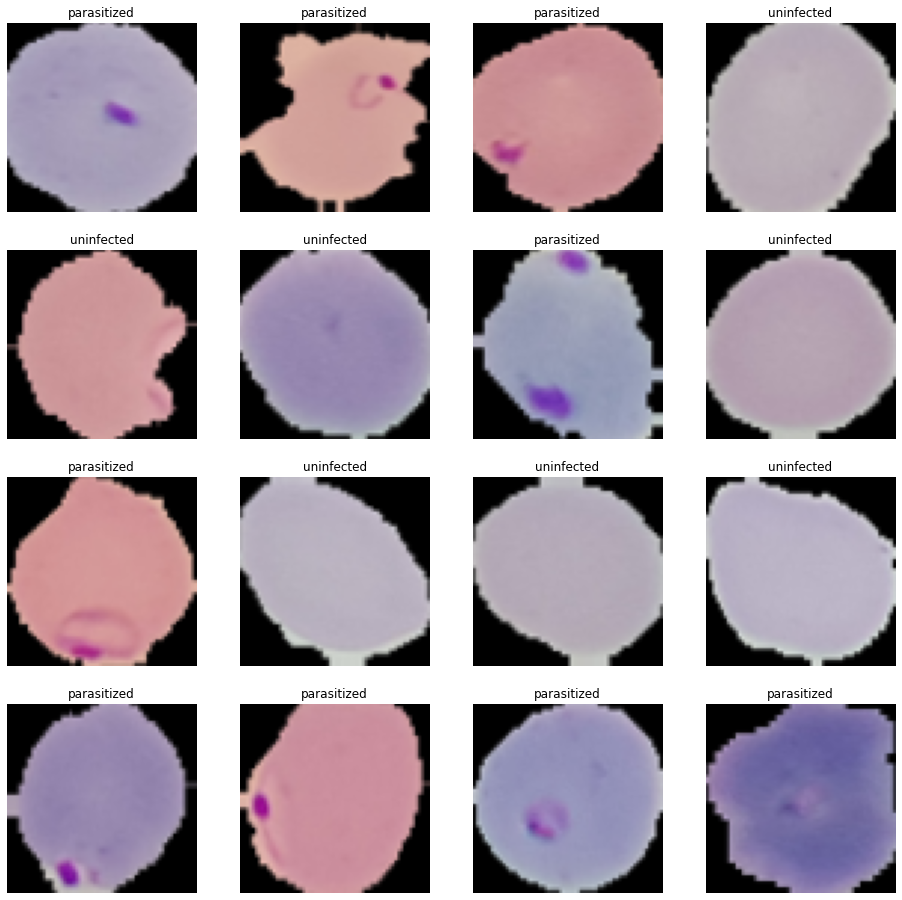

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

###<b>Building the Model

In [ ]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))

model3.add(LeakyReLU(alpha=0.1))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model3.add(LeakyReLU(alpha=0.1))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same" ))

model3.add(LeakyReLU(alpha=0.1))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model3.add(LeakyReLU(alpha=0.1))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model3.add(LeakyReLU(alpha=0.1))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dense(512, activation = "relu"))

model3.add(Dropout(0.2))

model3.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model3.summary()

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model3.compile(loss ='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history3 = model3.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32,
                                  callbacks= callbacks, 
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 31s 73ms/step - loss: 0.2328 - accuracy: 0.8878 - val_loss: 0.1085 - val_accuracy: 0.9726
Epoch 2/20
312/312 [==============================] - 22s 71ms/step - loss: 0.0883 - accuracy: 0.9703 - val_loss: 0.0885 - val_accuracy: 0.9726
Epoch 3/20
312/312 [==============================] - 22s 72ms/step - loss: 0.0753 - accuracy: 0.9756 - val_loss: 0.0774 - val_accuracy: 0.9780
Epoch 4/20
312/312 [==============================] - 22s 71ms/step - loss: 0.0738 - accuracy: 0.9758 - val_loss: 0.0675 - val_accuracy: 0.9800
Epoch 5/20
312/312 [==============================] - 23s 73ms/step - loss: 0.0699 - accuracy: 0.9769 - val_loss: 0.0703 - val_accuracy: 0.9788
Epoch 6/20
312/312 [==============================] - 22s 71ms/step - loss: 0.0652 - accuracy: 0.9778 - val_loss: 0.0813 - val_accuracy: 0.9734


###<B>Evaluating the model

<b>Plot the train and validation accuracy

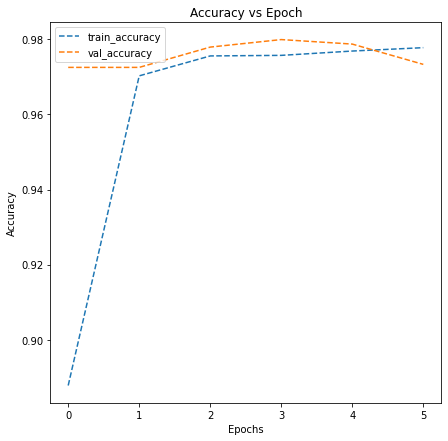

In [ ]:
# Potting the accuracies
plot_accuracy(history3)

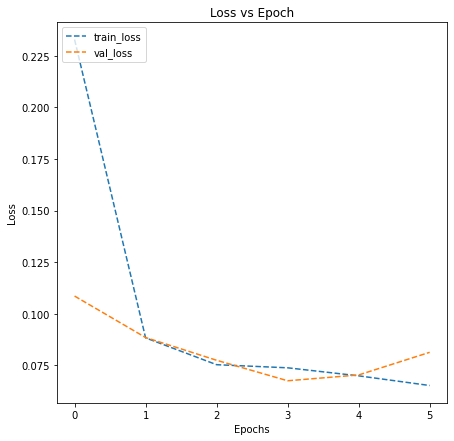

In [ ]:
plot_loss(history3)

In [ ]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy3[1])


82/82 [==============================] - 1s 5ms/step - loss: 0.0585 - accuracy: 0.9792

 Test_Accuracy:- 0.9792307615280151


<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



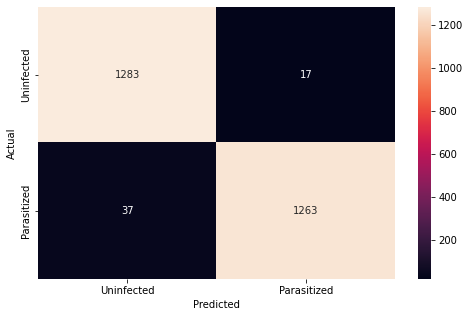

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model3.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b>Observations and insights:
The model used six epochs for training. At the 6th epoch, the training accuracy was 0.98, the training loss was 0.065, the validation accuracy was 0.97, and the validation loss was 0.081.
When testing the model, it yielded a 0.98 F1 score for both parasitized and uninfected images, and the overall accuracy was 98%. The model misclassified 37 parasitized images and 17 uninfected images.
The execution time of the fitting process was 142 seconds. 
 


###<b> Second Model Using Shear

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(
                                  #horizontal_flip = True, 
                                  #vertical_flip = False, 
                                  #height_shift_range= 0.1, 
                                  #width_shift_range=0.1, 
                                  #rotation_range=20, 
                                  shear_range = 0.1
                                  #zoom_range=0.1
                                   )

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

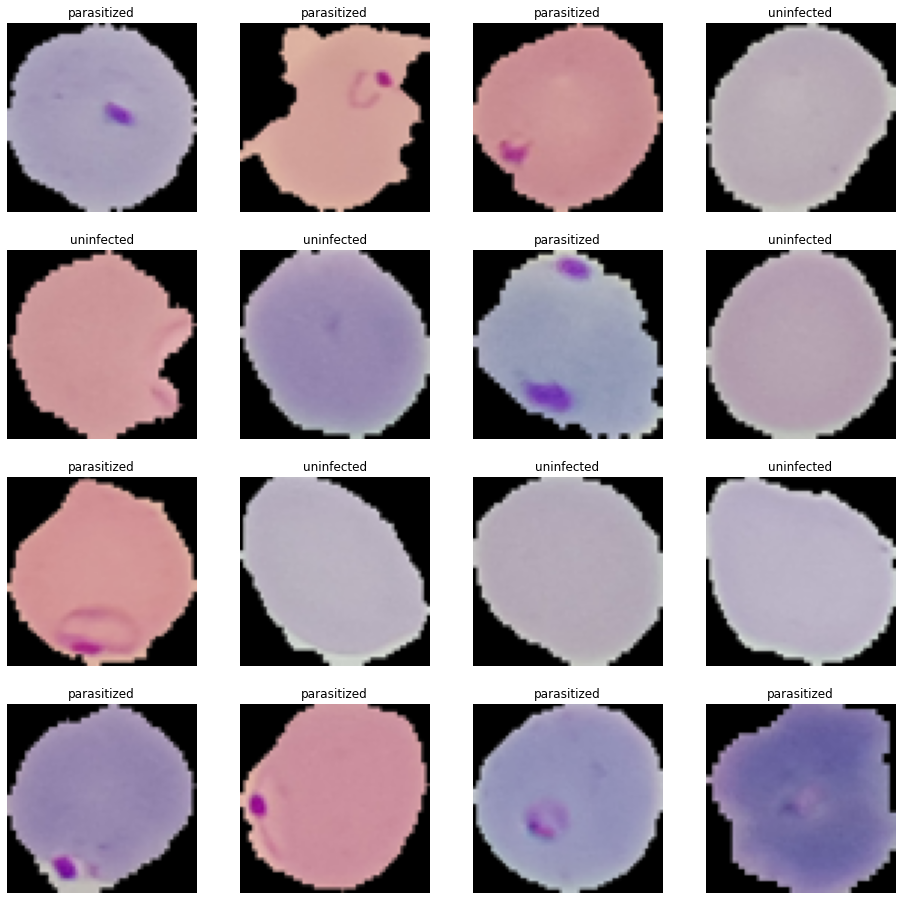

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

###<b>Building the Model

In [ ]:
model4 = Sequential()

model4.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))

model4.add(LeakyReLU(alpha=0.1))

model4.add(MaxPooling2D(pool_size = 2))

model4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model4.add(LeakyReLU(alpha=0.1))

model4.add(MaxPooling2D(pool_size = 2))

model4.add(Dropout(0.2))

model4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same" ))

model4.add(LeakyReLU(alpha=0.1))

model4.add(MaxPooling2D(pool_size = 2))

model4.add(Dropout(0.2))

model4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model4.add(LeakyReLU(alpha=0.1))

model4.add(MaxPooling2D(pool_size = 2))

model4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model4.add(LeakyReLU(alpha=0.1))

model4.add(MaxPooling2D(pool_size = 2))

model4.add(BatchNormalization())

model4.add(Flatten())

model4.add(Dense(512, activation = "relu"))

model4.add(Dropout(0.2))

model4.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model4.summary()

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model4.compile(loss ='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history4 = model4.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32,
                                  callbacks= callbacks, 
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 25s 77ms/step - loss: 0.3536 - accuracy: 0.8184 - val_loss: 0.1215 - val_accuracy: 0.9740
Epoch 2/20
312/312 [==============================] - 22s 72ms/step - loss: 0.0950 - accuracy: 0.9672 - val_loss: 0.0814 - val_accuracy: 0.9720
Epoch 3/20
312/312 [==============================] - 23s 72ms/step - loss: 0.0795 - accuracy: 0.9731 - val_loss: 0.1022 - val_accuracy: 0.9665
Epoch 4/20
312/312 [==============================] - 23s 72ms/step - loss: 0.0782 - accuracy: 0.9744 - val_loss: 0.0702 - val_accuracy: 0.9788
Epoch 5/20
312/312 [==============================] - 24s 77ms/step - loss: 0.0657 - accuracy: 0.9774 - val_loss: 0.0679 - val_accuracy: 0.9792
Epoch 6/20
312/312 [==============================] - 22s 71ms/step - loss: 0.0648 - accuracy: 0.9779 - val_loss: 0.0841 - val_accuracy: 0.9744
Epoch 7/20
312/312 [==============================] - 23s 72ms/step - loss: 0.0643 - accuracy: 0.9778 - val_loss: 0.0733 - val_accuracy:

###<B>Evaluating the model

<b>Plot the train and validation accuracy

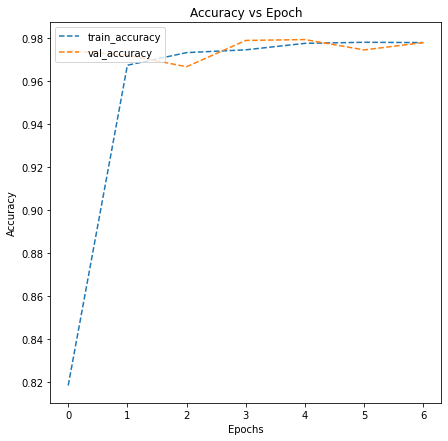

In [ ]:
# Potting the accuracies
plot_accuracy(history4)

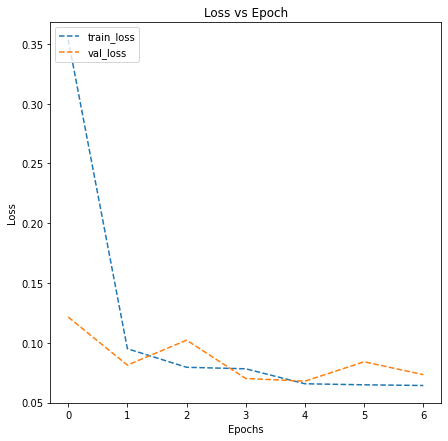

In [ ]:
plot_loss(history4)

In [ ]:
# Evaluating the model on test data
accuracy4 = model4.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy4[1])


82/82 [==============================] - 0s 4ms/step - loss: 0.0503 - accuracy: 0.9827

 Test_Accuracy:- 0.982692301273346


82/82 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



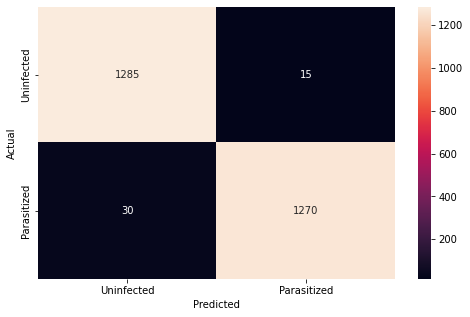

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b>Observations and insights:
The model used seven epochs for training. At the 7th epoch, the training accuracy was 0.98, the training loss was 0.073, the validation accuracy was 0.98, and the validation loss was 0.073.
When testing the model, it yielded a 0.98 F1 score for both parasitized and uninfected images, and the overall accuracy was 98%. The model misclassified 30 parasitized images and 15 uninfected images. 
The execution time of the fitting process was 162 seconds.
 


###<b> Third Model Using Rotation

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(
                                  #horizontal_flip = True, 
                                  #vertical_flip = False, 
                                  #height_shift_range= 0.1, 
                                  #width_shift_range=0.1, 
                                  rotation_range=20 
                                  #shear_range = 0.1,
                                  #zoom_range=0.1
                                   )

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

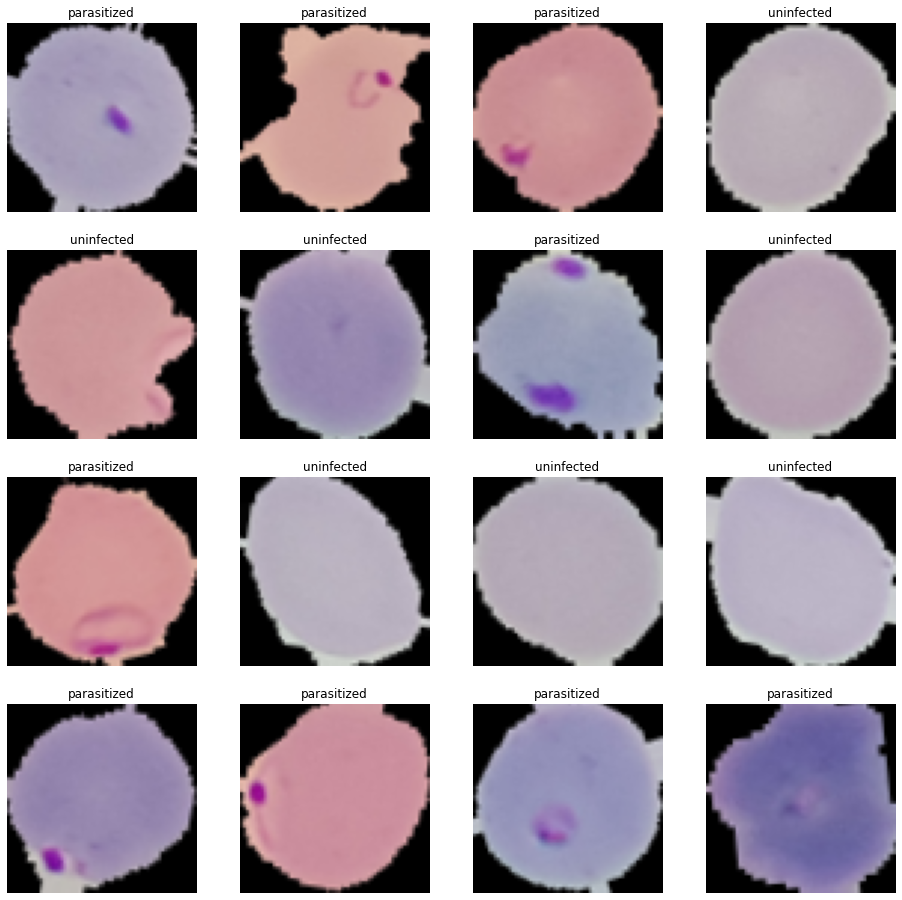

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

###<b>Building the Model

In [ ]:
model5 = Sequential()

model5.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))

model5.add(LeakyReLU(alpha=0.1))

model5.add(MaxPooling2D(pool_size = 2))

model5.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model5.add(LeakyReLU(alpha=0.1))

model5.add(MaxPooling2D(pool_size = 2))

model5.add(Dropout(0.2))

model5.add(Conv2D(filters = 32, kernel_size = 2, padding = "same" ))

model5.add(LeakyReLU(alpha=0.1))

model5.add(MaxPooling2D(pool_size = 2))

model5.add(Dropout(0.2))

model5.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model5.add(LeakyReLU(alpha=0.1))

model5.add(MaxPooling2D(pool_size = 2))

model5.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model5.add(LeakyReLU(alpha=0.1))

model5.add(MaxPooling2D(pool_size = 2))

model5.add(BatchNormalization())

model5.add(Flatten())

model5.add(Dense(512, activation = "relu"))

model5.add(Dropout(0.2))

model5.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model5.summary()

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model5.compile(loss ='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history5 = model5.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32,
                                  callbacks= callbacks, 
                                  epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 25s 75ms/step - loss: 0.4944 - accuracy: 0.7257 - val_loss: 0.1457 - val_accuracy: 0.9617
Epoch 2/10
312/312 [==============================] - 24s 77ms/step - loss: 0.0970 - accuracy: 0.9666 - val_loss: 0.0933 - val_accuracy: 0.9694
Epoch 3/10
312/312 [==============================] - 23s 75ms/step - loss: 0.0837 - accuracy: 0.9722 - val_loss: 0.0839 - val_accuracy: 0.9742
Epoch 4/10
312/312 [==============================] - 23s 73ms/step - loss: 0.0783 - accuracy: 0.9741 - val_loss: 0.0774 - val_accuracy: 0.9764
Epoch 5/10
312/312 [==============================] - 24s 78ms/step - loss: 0.0725 - accuracy: 0.9758 - val_loss: 0.0714 - val_accuracy: 0.9790
Epoch 6/10
312/312 [==============================] - 23s 73ms/step - loss: 0.0694 - accuracy: 0.9766 - val_loss: 0.0945 - val_accuracy: 0.9698
Epoch 7/10
312/312 [==============================] - 23s 74ms/step - loss: 0.0665 - accuracy: 0.9780 - val_loss: 0.0656 - val_accuracy:

###<B>Evaluating the model

<b>Plot the train and validation accuracy

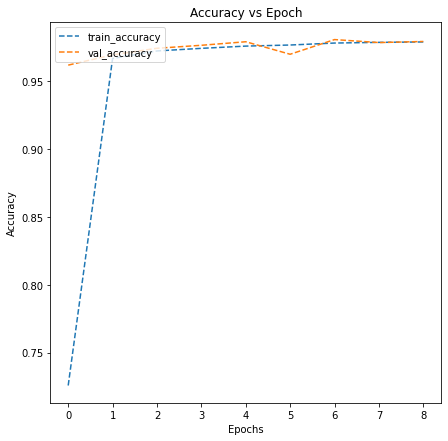

In [ ]:
# Potting the accuracies
plot_accuracy(history5)

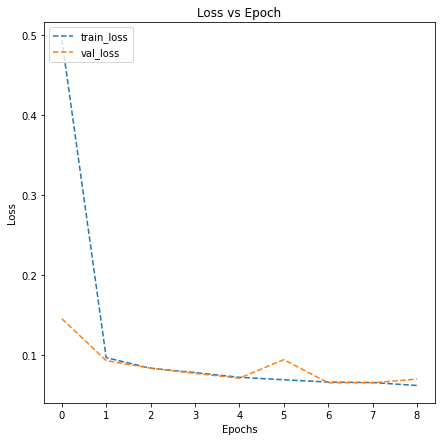

In [ ]:
plot_loss(history5)

In [ ]:
# Evaluating the model on test data
accuracy5 = model5.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy5[1])


82/82 [==============================] - 0s 4ms/step - loss: 0.0553 - accuracy: 0.9835

 Test_Accuracy:- 0.9834615588188171


82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



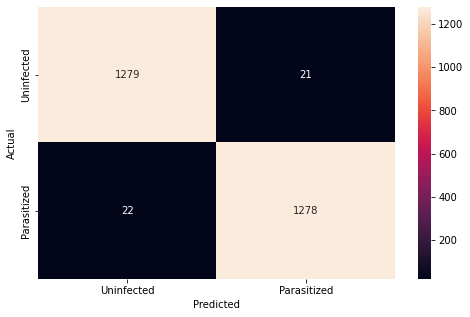

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model5.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b>Observations and insights:
The model used nine epochs for training. At the 9th epoch, the training accuracy was 0.98, the training loss was 0.062 the validation accuracy was 0.98, and the validation loss was 0.07.
When testing the model, it yielded a 0.98 F1 score for both parasitized and uninfected images, and the overall accuracy was 98%. The model misclassified 22 parasitized images and 21 uninfected images. 
The execution time of the fitting process was 211 seconds.
 


###<b> Forth Model Using Width Shift 

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(
                                  #horizontal_flip = True, 
                                  #vertical_flip = False, 
                                  #height_shift_range= 0.1, 
                                  width_shift_range=0.1 
                                  #rotation_range=20,
                                  #shear_range = 0.1
                                  #zoom_range=0.1
                                   )

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

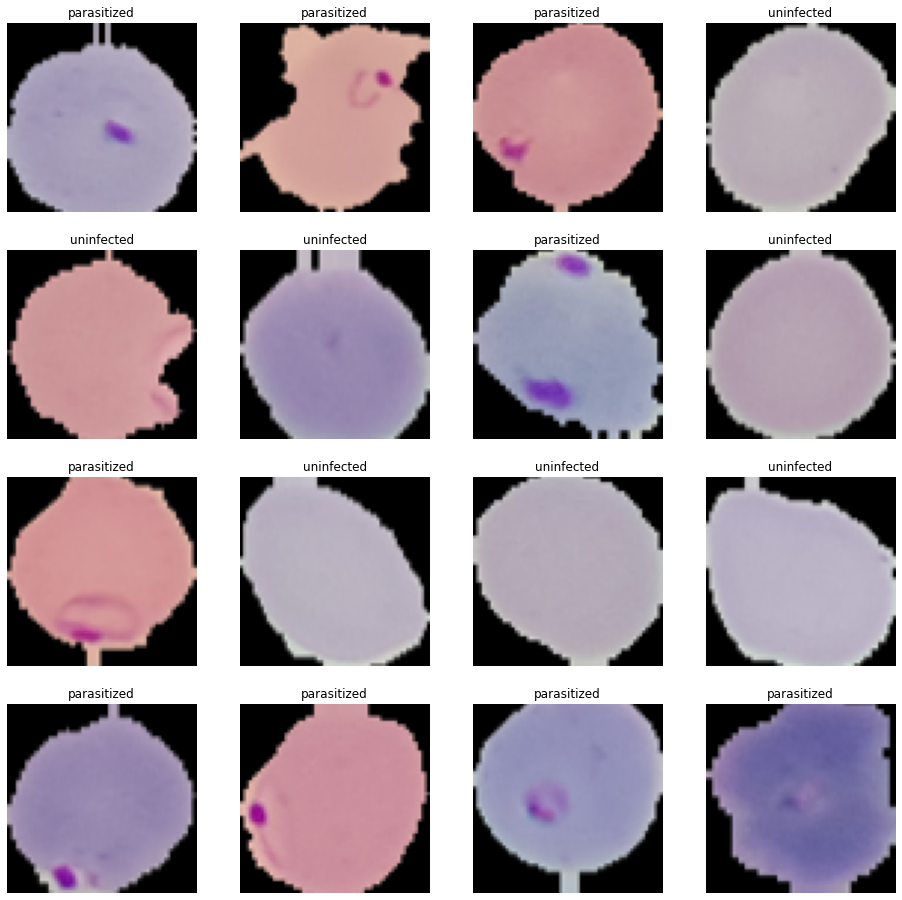

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

###<b>Building the Model

In [ ]:
model6 = Sequential()

model6.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))

model6.add(LeakyReLU(alpha=0.1))

model6.add(MaxPooling2D(pool_size = 2))

model6.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model6.add(LeakyReLU(alpha=0.1))

model6.add(MaxPooling2D(pool_size = 2))

model6.add(Dropout(0.2))

model6.add(Conv2D(filters = 32, kernel_size = 2, padding = "same" ))

model6.add(LeakyReLU(alpha=0.1))

model6.add(MaxPooling2D(pool_size = 2))

model6.add(Dropout(0.2))

model6.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model6.add(LeakyReLU(alpha=0.1))

model6.add(MaxPooling2D(pool_size = 2))

model6.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model6.add(LeakyReLU(alpha=0.1))

model6.add(MaxPooling2D(pool_size = 2))

model6.add(BatchNormalization())

model6.add(Flatten())

model6.add(Dense(512, activation = "relu"))

model6.add(Dropout(0.2))

model6.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model6.summary()

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model6.compile(loss ='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history6 = model6.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32,
                                  callbacks= callbacks, 
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 24s 78ms/step - loss: 0.3695 - accuracy: 0.8144 - val_loss: 0.1247 - val_accuracy: 0.9649
Epoch 2/20
312/312 [==============================] - 25s 80ms/step - loss: 0.1042 - accuracy: 0.9649 - val_loss: 0.0942 - val_accuracy: 0.9710
Epoch 3/20
312/312 [==============================] - 25s 80ms/step - loss: 0.0899 - accuracy: 0.9708 - val_loss: 0.0773 - val_accuracy: 0.9786
Epoch 4/20
312/312 [==============================] - 23s 74ms/step - loss: 0.0810 - accuracy: 0.9724 - val_loss: 0.0818 - val_accuracy: 0.9728
Epoch 5/20
312/312 [==============================] - 23s 74ms/step - loss: 0.0775 - accuracy: 0.9748 - val_loss: 0.0724 - val_accuracy: 0.9770
Epoch 6/20
312/312 [==============================] - 24s 76ms/step - loss: 0.0706 - accuracy: 0.9767 - val_loss: 0.0660 - val_accuracy: 0.9804
Epoch 7/20
312/312 [==============================] - 24s 76ms/step - loss: 0.0712 - accuracy: 0.9768 - val_loss: 0.0720 - val_accuracy:

###<B>Evaluating the model

<b>Plot the train and validation accuracy

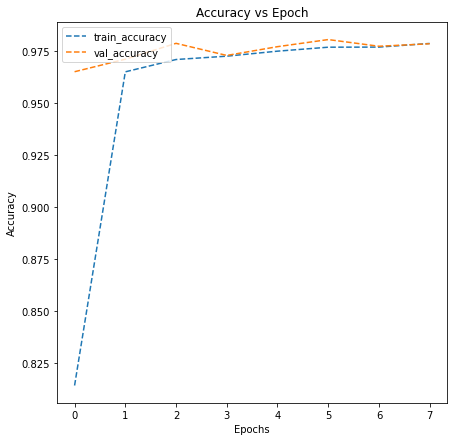

In [ ]:
# Potting the accuracies
plot_accuracy(history6)

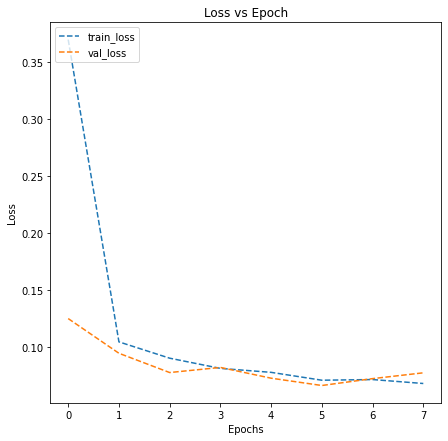

In [ ]:
plot_loss(history6)

In [ ]:
# Evaluating the model on test data
accuracy6 = model6.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy6[1])


82/82 [==============================] - 0s 4ms/step - loss: 0.0579 - accuracy: 0.9808

 Test_Accuracy:- 0.9807692170143127


82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



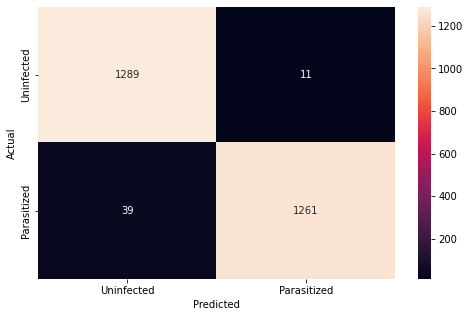

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model6.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b>Observations and insights:
The model used eight epochs for training. At the 8th epoch, the training accuracy was 0.98, the training loss was 0.068 the validation accuracy was 0.98, and the validation loss was 0.077.
When testing the model, it yielded a 0.98 F1 score for both parasitized and uninfected images, and the overall accuracy was 98%. The model misclassified 39 parasitized images and 11 uninfected images. 
The execution time of the fitting process was 191 seconds.


###<b> Fifth Model Using Height Shift 

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(
                                  #horizontal_flip = True, 
                                  #vertical_flip = False, 
                                  height_shift_range= 0.1
                                  #width_shift_range=0.1, 
                                  #rotation_range=20, 
                                  #shear_range = 0.1
                                  #zoom_range=0.1
                                   )

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

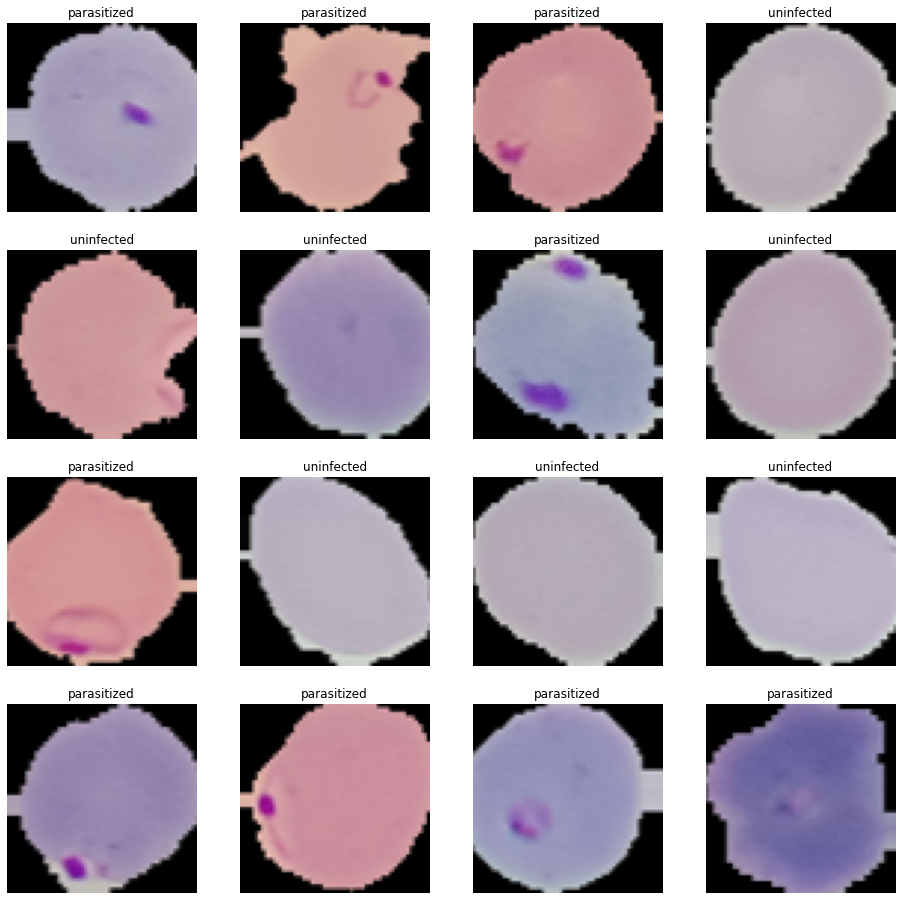

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

###<b>Building the Model

In [ ]:
model7 = Sequential()

model7.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))

model7.add(LeakyReLU(alpha=0.1))

model7.add(MaxPooling2D(pool_size = 2))

model7.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model7.add(LeakyReLU(alpha=0.1))

model7.add(MaxPooling2D(pool_size = 2))

model7.add(Dropout(0.2))

model7.add(Conv2D(filters = 32, kernel_size = 2, padding = "same" ))

model7.add(LeakyReLU(alpha=0.1))

model7.add(MaxPooling2D(pool_size = 2))

model7.add(Dropout(0.2))

model7.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model7.add(LeakyReLU(alpha=0.1))

model7.add(MaxPooling2D(pool_size = 2))

model7.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model7.add(LeakyReLU(alpha=0.1))

model7.add(MaxPooling2D(pool_size = 2))

model7.add(BatchNormalization())

model7.add(Flatten())

model7.add(Dense(512, activation = "relu"))

model7.add(Dropout(0.2))

model7.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model7.summary()

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model7.compile(loss ='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history7 = model7.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32,
                                  callbacks= callbacks, 
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 26s 82ms/step - loss: 0.3127 - accuracy: 0.8429 - val_loss: 0.1645 - val_accuracy: 0.9521
Epoch 2/20
312/312 [==============================] - 26s 83ms/step - loss: 0.0979 - accuracy: 0.9670 - val_loss: 0.0863 - val_accuracy: 0.9694
Epoch 3/20
312/312 [==============================] - 27s 85ms/step - loss: 0.0829 - accuracy: 0.9732 - val_loss: 0.0799 - val_accuracy: 0.9764
Epoch 4/20
312/312 [==============================] - 23s 74ms/step - loss: 0.0763 - accuracy: 0.9757 - val_loss: 0.0750 - val_accuracy: 0.9758
Epoch 5/20
312/312 [==============================] - 24s 76ms/step - loss: 0.0712 - accuracy: 0.9777 - val_loss: 0.0667 - val_accuracy: 0.9824
Epoch 6/20
312/312 [==============================] - 24s 78ms/step - loss: 0.0670 - accuracy: 0.9776 - val_loss: 0.0663 - val_accuracy: 0.9806
Epoch 7/20
312/312 [==============================] - 23s 75ms/step - loss: 0.0660 - accuracy: 0.9778 - val_loss: 0.0660 - val_accuracy:

###<B>Evaluating the model

<b>Plot the train and validation accuracy

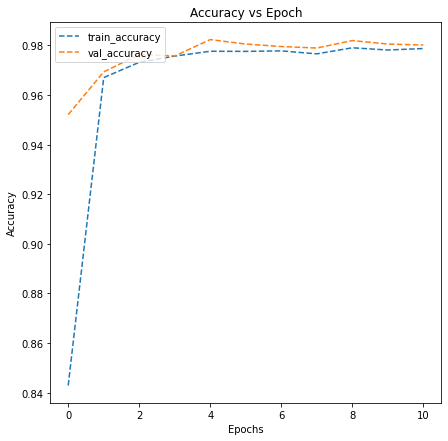

In [ ]:
# Potting the accuracies
plot_accuracy(history7)

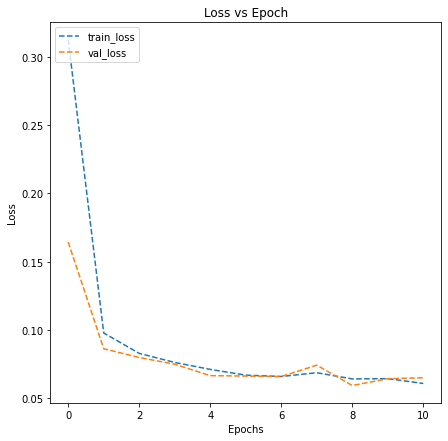

In [ ]:
plot_loss(history7)

In [ ]:
# Evaluating the model on test data
accuracy7 = model7.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy7[1])


82/82 [==============================] - 0s 4ms/step - loss: 0.0487 - accuracy: 0.9827

 Test_Accuracy:- 0.982692301273346


82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



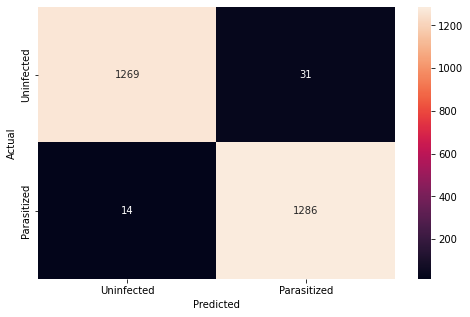

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model7.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b>Observations and insights:
The model used 11 epochs for training. At the 11th epoch, the training accuracy was 0.98, the training loss was 0.06, the validation accuracy was 0.98, and the validation loss was 0.065.
When testing the model, it yielded a 0.98 F1 score for both parasitized and uninfected images, and the overall accuracy was 98%. The model misclassified 14 parasitized images and 31 uninfected images. 
The execution time of the fitting process was 266 seconds.


###<b> Sixth Model Using Vertical Flip

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(
                                  #horizontal_flip = True, 
                                  vertical_flip = True
                                  #height_shift_range= 0.1, 
                                  #width_shift_range=0.1, 
                                  #rotation_range=20, 
                                  #shear_range = 0.1,
                                  #zoom_range=0.1
                                   )

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

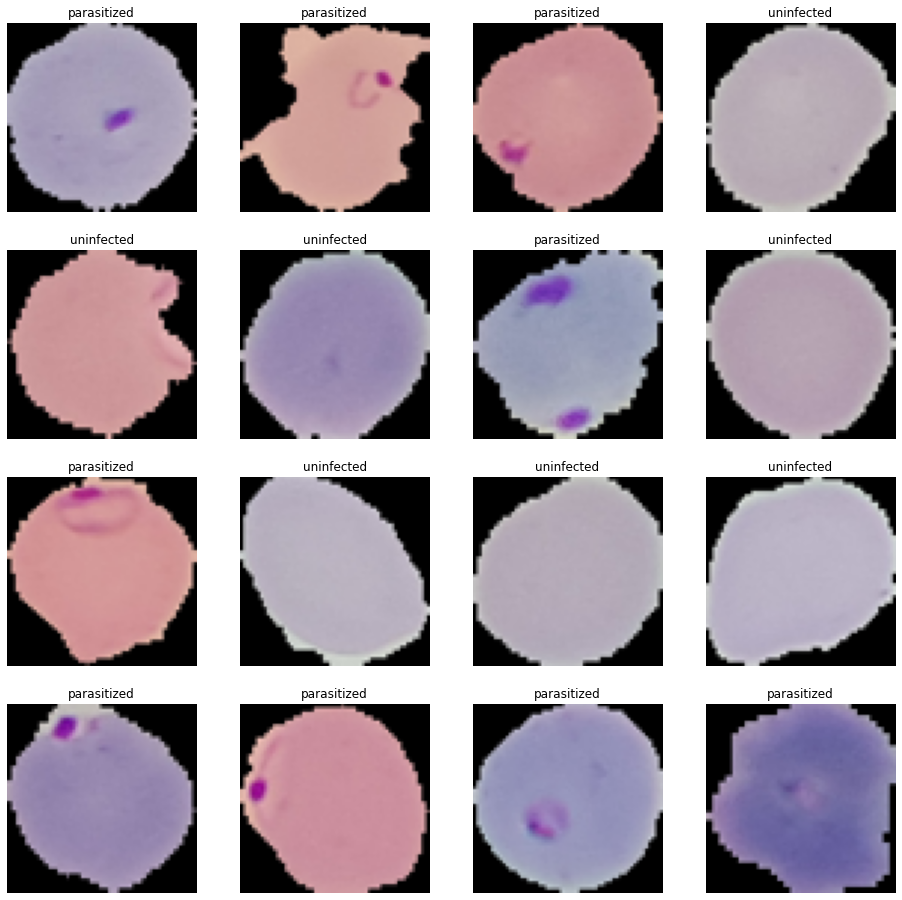

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

###<b>Building the Model

In [ ]:
model8 = Sequential()

model8.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))

model8.add(LeakyReLU(alpha=0.1))

model8.add(MaxPooling2D(pool_size = 2))

model8.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model8.add(LeakyReLU(alpha=0.1))

model8.add(MaxPooling2D(pool_size = 2))

model8.add(Dropout(0.2))

model8.add(Conv2D(filters = 32, kernel_size = 2, padding = "same" ))

model8.add(LeakyReLU(alpha=0.1))

model8.add(MaxPooling2D(pool_size = 2))

model8.add(Dropout(0.2))

model8.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model8.add(LeakyReLU(alpha=0.1))

model8.add(MaxPooling2D(pool_size = 2))

model8.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model8.add(LeakyReLU(alpha=0.1))

model8.add(MaxPooling2D(pool_size = 2))

model8.add(BatchNormalization())

model8.add(Flatten())

model8.add(Dense(512, activation = "relu"))

model8.add(Dropout(0.2))

model8.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model8.summary()

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model8.compile(loss ='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

model8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history8 = model8.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32,
                                  callbacks= callbacks, 
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 13s 13ms/step - loss: 0.2541 - accuracy: 0.8735 - val_loss: 0.1078 - val_accuracy: 0.9690
Epoch 2/20
312/312 [==============================] - 4s 12ms/step - loss: 0.0874 - accuracy: 0.9706 - val_loss: 0.0920 - val_accuracy: 0.9702
Epoch 3/20
312/312 [==============================] - 4s 12ms/step - loss: 0.0785 - accuracy: 0.9746 - val_loss: 0.0758 - val_accuracy: 0.9768
Epoch 4/20
312/312 [==============================] - 4s 12ms/step - loss: 0.0740 - accuracy: 0.9755 - val_loss: 0.0656 - val_accuracy: 0.9794
Epoch 5/20
312/312 [==============================] - 4s 12ms/step - loss: 0.0670 - accuracy: 0.9775 - val_loss: 0.0677 - val_accuracy: 0.9806
Epoch 6/20
312/312 [==============================] - 4s 12ms/step - loss: 0.0674 - accuracy: 0.9770 - val_loss: 0.0714 - val_accuracy: 0.9764


###<B>Evaluating the model

<b>Plot the train and validation accuracy

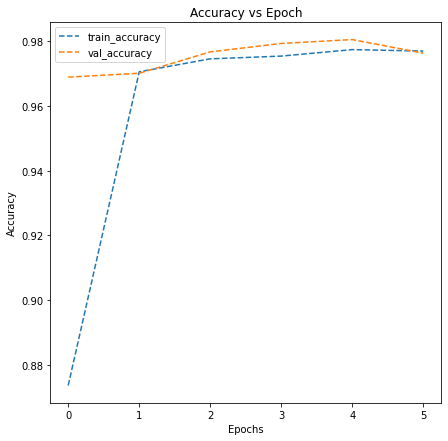

In [ ]:
# Potting the accuracies
plot_accuracy(history8)

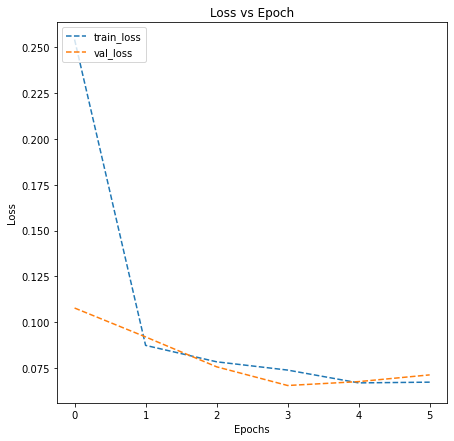

In [ ]:
plot_loss(history8)

In [ ]:
# Evaluating the model on test data
accuracy8 = model8.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy8[1])


82/82 [==============================] - 1s 5ms/step - loss: 0.0620 - accuracy: 0.9796

 Test_Accuracy:- 0.9796153903007507


82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



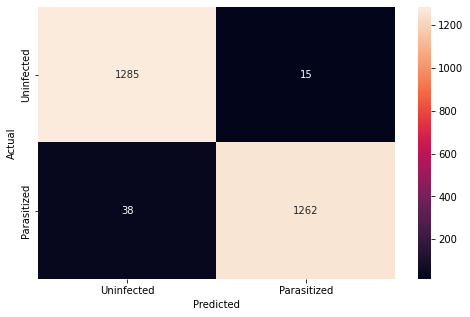

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model8.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b>Observations and insights:
The model used six epochs for training. At the 6th epoch, the training accuracy was 0.98, the training loss was 0.067, the validation accuracy was 0.98, and the validation loss was 0.071.
When testing the model, it yielded a 0.98 F1 score for both parasitized and uninfected images, and the overall accuracy was 98%. The model misclassified 38 parasitized images and 15 uninfected images. 
The execution time of the fitting process was 33 seconds.


###<b> Seventh Model Using Horizontal Flip 

In [ ]:
backend.clear_session() # Clearing backend for new model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(
                                  horizontal_flip = True
                                  #vertical_flip = False, 
                                  #height_shift_range= 0.1, 
                                  #width_shift_range=0.1, 
                                  #rotation_range=20, 
                                  #shear_range = 0.1,
                                  #zoom_range=0.1
                                   )

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

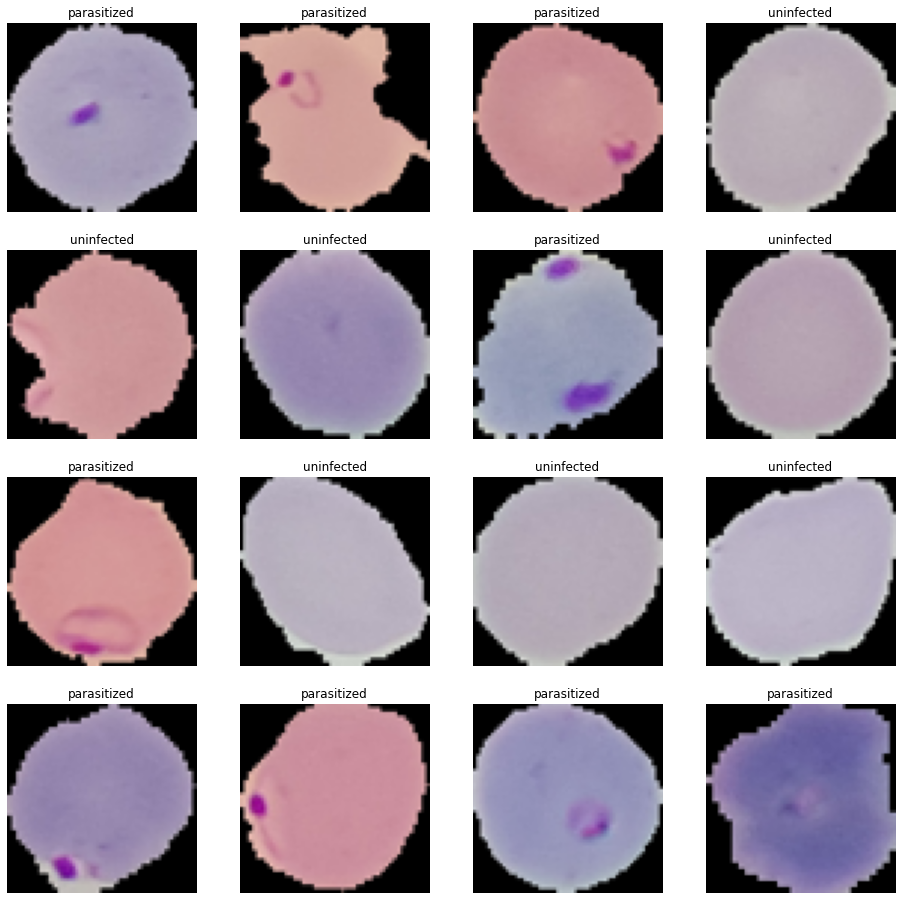

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

###<b>Building the Model

In [ ]:
model9 = Sequential()

model9.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))

model9.add(LeakyReLU(alpha=0.1))

model9.add(MaxPooling2D(pool_size = 2))

model9.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model9.add(LeakyReLU(alpha=0.1))

model9.add(MaxPooling2D(pool_size = 2))

model9.add(Dropout(0.2))

model9.add(Conv2D(filters = 32, kernel_size = 2, padding = "same" ))

model9.add(LeakyReLU(alpha=0.1))

model9.add(MaxPooling2D(pool_size = 2))

model9.add(Dropout(0.2))

model9.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model9.add(LeakyReLU(alpha=0.1))

model9.add(MaxPooling2D(pool_size = 2))

model9.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))

model9.add(LeakyReLU(alpha=0.1))

model9.add(MaxPooling2D(pool_size = 2))

model9.add(BatchNormalization())

model9.add(Flatten())

model9.add(Dense(512, activation = "relu"))

model9.add(Dropout(0.2))

model9.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model9.summary()

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model9.compile(loss ='binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history9 = model9.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32,
                                  callbacks= callbacks, 
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 5s 13ms/step - loss: 0.4425 - accuracy: 0.7600 - val_loss: 0.1248 - val_accuracy: 0.9613
Epoch 2/20
312/312 [==============================] - 4s 12ms/step - loss: 0.0983 - accuracy: 0.9668 - val_loss: 0.0950 - val_accuracy: 0.9673
Epoch 3/20
312/312 [==============================] - 4s 12ms/step - loss: 0.0862 - accuracy: 0.9699 - val_loss: 0.0741 - val_accuracy: 0.9790
Epoch 4/20
312/312 [==============================] - 4s 13ms/step - loss: 0.0765 - accuracy: 0.9748 - val_loss: 0.0922 - val_accuracy: 0.9716
Epoch 5/20
312/312 [==============================] - 4s 13ms/step - loss: 0.0738 - accuracy: 0.9757 - val_loss: 0.0701 - val_accuracy: 0.9782
Epoch 6/20
312/312 [==============================] - 4s 13ms/step - loss: 0.0693 - accuracy: 0.9773 - val_loss: 0.0685 - val_accuracy: 0.9800
Epoch 7/20
312/312 [==============================] - 4s 12ms/step - loss: 0.0681 - accuracy: 0.9769 - val_loss: 0.0748 - val_accuracy: 0.9772

###<B>Evaluating the model

<b>Plot the train and validation accuracy

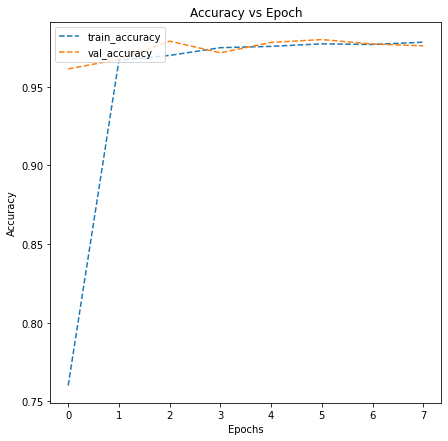

In [ ]:
# Potting the accuracies
plot_accuracy(history9)

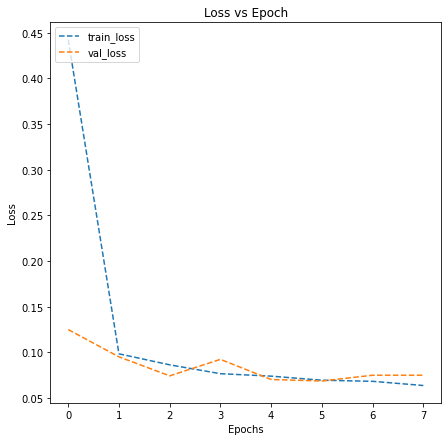

In [ ]:
plot_loss(history9)

In [ ]:
# Evaluating the model on test data
accuracy9 = model9.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy9[1])


82/82 [==============================] - 0s 4ms/step - loss: 0.0622 - accuracy: 0.9850

 Test_Accuracy:- 0.9850000143051147


82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.99      0.98      0.98      2600
weighted avg       0.99      0.98      0.98      2600



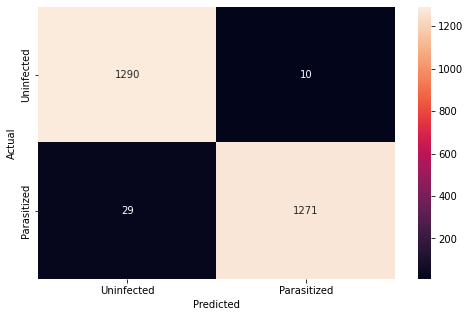

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model9.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b>Observations and insights:
The model used eight epochs for training. At the 8th epoch, the training accuracy was 0.98, the training loss was 0.064, the validation accuracy was 0.97, and the validation loss was 0.075.
When testing the model, it yielded a 0.98 F1 score for parasitized and 0.99 F1 scores for uninfected images, and the overall accuracy was 98%. The model misclassified 29 parasitized images and 10 uninfected images.
The execution time of the fitting process was 33 seconds.

###<b>Final Thoughts 
All models yielded similar results. Using any of the individual image data generator techniques and the CNN model we built will provide acceptable results. 
The difference in execution time might be because I had to restart the runtime at the sixth model, which is something for future investigation and improvement. 

In [ ]:
!jupyter nbconvert --to html Data_Augmentation_Comparison.ipynb